In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
import numpy as np
import xarray as xr
from scipy import stats as scistats
import seawater as sw

import matplotlib.pyplot as plt

import traits_db
import metabolic as mi
import util

## Read traits and examine distributions

In [3]:
df = traits_db.df_mi
print(len(df))
df.head()

61


,Eo,Ao,Ac,Phi_crit,Phylum
0,-0.027836,0.264715,0.131959,2.006040,Crustacea
1,0.038027,0.252578,0.141861,1.780456,Crustacea
2,0.131972,0.230068,0.073638,3.124330,Crustacea
3,-0.030067,0.286307,0.174423,1.641453,Crustacea
4,0.362569,0.218524,0.048415,4.513525,Chordata


### Plot trait histograms

In [4]:
trait_pdfs = dict()

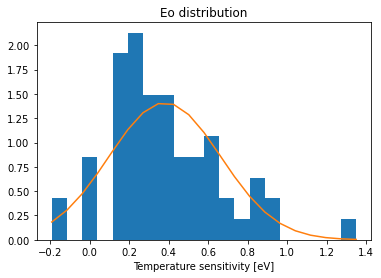

In [5]:
fig, ax = plt.subplots()

beta = scistats.norm.fit(df.Eo.values)

n, bins, h = ax.hist(df.Eo.values, 20, density=True);
pdf_fitted = scistats.norm.pdf(bins, *beta)
ax.plot(bins, pdf_fitted)
ax.set_title('Eo distribution')
ax.set_xlabel(util.attrs_label(df.Eo.attrs));

trait_pdfs['Eo'] = dict(
    bins=bins,
    func_form='norm',
    beta=beta
)

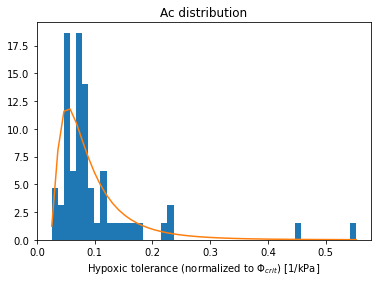

In [18]:
fig, ax = plt.subplots()

trait = 'Ac'
trait_values = df[trait].values

beta = scistats.lognorm.fit(trait_values)

n, bins, h = ax.hist(trait_values, 50, density=True);

pdf_fitted = scistats.lognorm.pdf(bins, *beta)
ax.plot(bins, pdf_fitted)
ax.set_title(f'{trait} distribution')
ax.set_xlabel(util.attrs_label(df[trait].attrs));

trait_pdfs[trait] = dict(
    bins=bins,
    func_form='log_norm',
    beta=beta
)

In [7]:
Phyla = list(df.Phylum.unique())
Phyla

['Crustacea', 'Chordata', 'Mollusca', 'Cnidaria', 'Tunicata']

In [23]:
df.Ac.max()

0.552778623242043

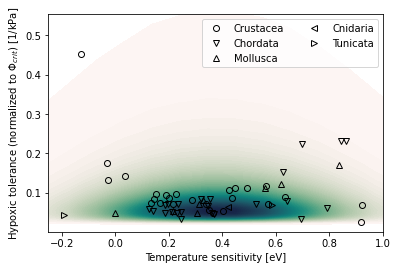

In [30]:
import cmocean
markerorder = ["o", "v", "^", "<", ">", "s", "p", "P"]

x_beta = trait_pdfs['Eo']['beta']
y_beta = trait_pdfs['Ac']['beta']

Eo_bins = np.linspace(-1., 2., 30)
Ac_bins = np.logspace(-3, np.log10(df.Ac.max()), 50)

X, Y = np.meshgrid(Eo_bins, Ac_bins)
Z1, Z2 = np.meshgrid(scistats.norm.pdf(Eo_bins, *x_beta), 
                     scistats.lognorm.pdf(Ac_bins, *y_beta)
                    )

fig, ax = plt.subplots() #figsize=(6, 6))

mx = np.max(Z1*Z2)
cf = ax.contourf(X, Y, Z1*Z2 / mx, 
            cmap=cmocean.cm.tempo, 
            levels=np.arange(0.001, 1.02, 0.01),
           )
#plt.colorbar(cf)

for i, phylum in enumerate(Phyla):
    ndx = df.Phylum == phylum
    ax.plot(df.Eo.loc[ndx], df.Ac.loc[ndx], 
            linestyle='none', 
            marker=markerorder[i], 
            color='k',
            markerfacecolor='none',
            label=phylum,
           )

ax.set_xlabel(util.attrs_label(df.Eo.attrs));
ax.set_ylabel(util.attrs_label(df.Ac.attrs));

ax.set_xlim((-0.25, 1));
#ax.set_ylim((0, 0.4));

ax.legend(ncol=2);
plt.savefig(f'trait-space-idealized.png', dpi=300)

In [14]:
25/100

0.25

In [85]:
import thermodyn
ds = xr.merge((
    util.retrieve_woa_dataset('oxygen', 0).isel(time=0, drop=True)[['o_an']],
    util.retrieve_woa_dataset(['temperature', 'salinity'], 0).isel(time=0, drop=True)[['t_an', 's_an']],
)).sel(depth=slice(0, 1000.))

depth = xr.full_like(ds.t_an, fill_value=1.) * ds.depth
ds['pO2'] = thermodyn.compute_pO2(ds.o_an, ds.t_an, ds.s_an, depth)
ds = ds.compute()
ds

<xarray.Dataset>
Dimensions:  (depth: 47, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 0.0 5.0 10.0 15.0 20.0 ... 850.0 900.0 950.0 1e+03
Data variables:
    o_an     (depth, lat, lon) float32 nan nan nan nan ... 303.3 303.3 303.3
    t_an     (depth, lat, lon) float32 nan nan nan ... -0.1925 -0.1925 -0.1925
    s_an     (depth, lat, lon) float32 nan nan nan nan ... 34.91 34.91 34.91
    pO2      (depth, lat, lon) float32 nan nan nan nan ... 20.49 20.49 20.49
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : mole_concentrat...
    summary:                         Climatological mean dissolved oxygen for...
    references:                      Garcia, H. E., K. Weathers, C. R. Paver,...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29

In [86]:
#Eo = xr.DataArray(Eo_bins, dims=('Eo'))
#Ac = xr.DataArray(Ac_bins, dims=('Ac'))

In [87]:
dEdTbar = -0.0226

In [96]:
import metabolic as mi
from itertools import product
nj, ni = len(Eo_bins), len(Ac_bins)

vol = np.empty((nj, ni))

for j, i in product(range(nj), range(ni)):
    phi_prime = mi.Phi(ds.pO2, ds.t_an, Ac_bins[i], Eo_bins[j], dEodT=dEdTbar)
    vol[j, i] = xr.where(phi_prime > 1., 1., 0.).sum()
    

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


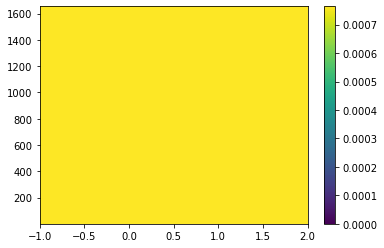

In [101]:
plt.pcolormesh(Eo_bins, Ac_bins, vol.T / vol.sum())
plt.colorbar()

In [ ]:
plt.pcolormesh(vol)


## Demonstrate root finding technique to solve to ATmax

Loop over traits and values of pO$_2$ to find ATmax

cannot find root: Ac = 2.613597328966256; Eo = -0.191; pO2 = 0
cannot find root: Ac = 2.613597328966256; Eo = -0.191; pO2 = 0.25
cannot find root: Ac = 2.613597328966256; Eo = -0.191; pO2 = 0.5
cannot find root: Ac = 2.613597328966256; Eo = -0.191; pO2 = 1.0
cannot find root: Ac = 2.613597328966256; Eo = -0.191; pO2 = 0
cannot find root: Ac = 2.613597328966256; Eo = -0.191; pO2 = 0.25
cannot find root: Ac = 2.613597328966256; Eo = -0.191; pO2 = 0.5
cannot find root: Ac = 2.613597328966256; Eo = -0.191; pO2 = 1.0
cannot find root: Ac = 2.613597328966256; Eo = 0.3389; pO2 = 0
cannot find root: Ac = 2.613597328966256; Eo = 0.3389; pO2 = 0.25
cannot find root: Ac = 2.613597328966256; Eo = 0.3389; pO2 = 0.5
cannot find root: Ac = 2.613597328966256; Eo = 0.3389; pO2 = 1.0
cannot find root: Ac = 2.613597328966256; Eo = 0.3389; pO2 = 0
cannot find root: Ac = 2.613597328966256; Eo = 0.3389; pO2 = 0.25
cannot find root: Ac = 2.613597328966256; Eo = 0.3389; pO2 = 0.5
cannot find root: Ac = 2.6135

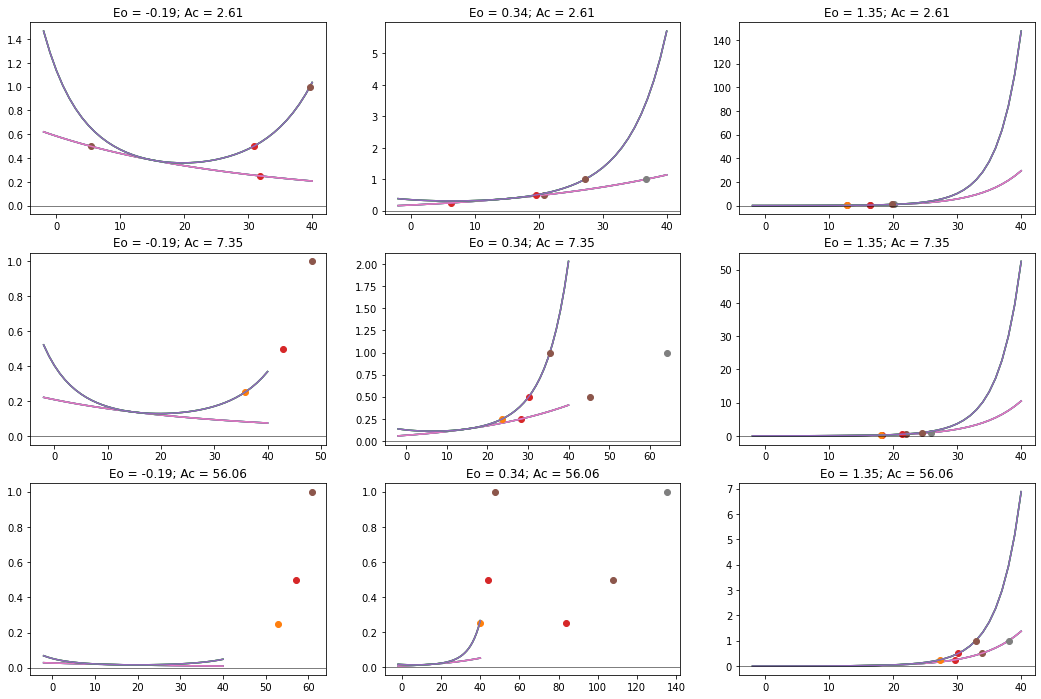

In [9]:
Ac_dist = np.percentile(df.Ac, [0, 50, 100])
Eo_dist = np.percentile(df.Eo, [0, 50, 100])

nrow = len(Ac_dist)
ncol = len(Eo_dist)
figsize = (6, 4)
fig, axs = plt.subplots(
    nrow, ncol, 
    figsize=(figsize[0]*ncol, figsize[1]*nrow),                       
    constrained_layout=False,
    squeeze=False,
)    

T = np.arange(-2., 41., 1.)

for i, j in product(range(nrow), range(ncol)):
    ax = axs[i, j]
    Ac = Ac_dist[i]
    Eo = Eo_dist[j]
    for dEodT in [0., 0.02,]:
        for po2 in [0, 0.25, 0.5, 1.]:
            p = ax.plot(T, mi.pO2_at_Phi_crit(T, Ac, Eo, dEodT))
            #print(f'cannot find root: Ac = {Ac}; Eo = {Eo}; pO2 = {po2}')
            Tmax_hi = mi.compute_ATmax(po2, Ac, Eo, dEodT=dEodT)
            ax.plot(Tmax_hi, po2, 'o')
    ax.axhline(0., lw=0.5, c='k')        
    ax.set_title(f'Eo = {Eo:0.2f}; Ac = {Ac:0.2f}')